# Ideas Dataset

Лаботоратория по искусственному интеллекту, Сбербанк. 

Авторы: [Борис Шминке](<mailto:Shminke.B.A@omega.sbrf.ru>), [Роза Айсина](<mailto:Aysina.R.M@omega.sbrf.ru>). 

О чем: применение рекомендательных систем к датасету историй. Схема разбиения - делим лог на две рандомные части.

## Содержание

1. [Импорты, создание спарк-сессии](#intro)
2. [Подготовка данных](#data-preparator)
3. [Рекомендатель на основе популярности](#popular-recommender)
3.1. [Запуск single модели](#popular-recommender-single)
3.2. [Подбор гиперпараметров](#popular-recommender-scenario)
4. [Рекомендатель на основе k-NN для объектов](#knn-recommender)
4.1. [Запуск single модели](#knn-recommender-single)
4.2. [Подбор гиперпараметров](#knn-recommender-scenario)

### Импорты, создание спарк-сессии <a name='intro'></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
import re
import sys
from collections import Counter
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, TimestampType

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.metrics.metrics import Metrics
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.models.knn_recommender import KNNRecommender
from sponge_bob_magic.models.neurocf_recommender import NeuroCFRecommender
from sponge_bob_magic.scenarios.knn_scenario import KNNScenario
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.validation_schemes import ValidationSchemes

In [5]:
# отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [8]:
spark_memory = "160g"
spark_cores = "30"
user_home = "/data/aysina-rm"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .config('spark.local.dir', os.path.join(user_home, "tmp"))
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

spark

In [9]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [10]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Подготовка данных <a name='data-preparator'></a>

Мердж двух датасетов за 17 и 18 год. Запускается один раз. 

In [11]:
def merge_data():
    user_item_data = (
        pd.read_csv(
            "/mnt/wind/ideas_data/2017.csv",
            sep=";",
            usecols=["id_project", "user_id", "type"],
            dtype=str
        ).append(
            pd.read_csv(
                "/mnt/wind/ideas_data/2018.csv",
                sep=";",
                usecols=["id_project", "user_id", "type"],
                dtype=str
            )
        ).query("type in ('Pim::IdeaBestPracticeVote', 'Pim::IdeaResourceVote', 'Pim::IdeaVote')")
        .drop(columns=["type"])
        .rename(columns={"user_id": "user_id", "id_project": "item_id"})
    )
    user_item_data.to_csv("data.csv", index=False)

In [12]:
path_log = '/data/share/ideas_data/data.csv'

In [13]:
dp = DataPreparator(spark)

In [14]:
df = dp.transform_log(
    path=path_log,
    format_type="csv",
    header=True,
    columns_names={
        "user_id": "user_id",
        "item_id": "item_id"
    }
).cache()

In [15]:
df.show(3)

+-------+-------+-------------------+----------+---------+
|user_id|item_id|          timestamp|   context|relevance|
+-------+-------+-------------------+----------+---------+
|  97636| 252605|1999-05-01 00:00:00|no_context|      1.0|
|  65714| 235144|1999-05-01 00:00:00|no_context|      1.0|
| 144702| 240366|1999-05-01 00:00:00|no_context|      1.0|
+-------+-------+-------------------+----------+---------+
only showing top 3 rows



In [16]:
df.count()

4691248

In [17]:
df.agg(*(sf.countDistinct(sf.col(c)).alias(c) for c in df.columns)).show()

+-------+-------+---------+-------+---------+
|user_id|item_id|timestamp|context|relevance|
+-------+-------+---------+-------+---------+
|  71343| 128558|        1|      1|        1|
+-------+-------+---------+-------+---------+



In [18]:
df.agg(sf.min(sf.col("timestamp")), sf.max(sf.col("timestamp"))).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|1999-05-01 00:00:00|1999-05-01 00:00:00|
+-------------------+-------------------+



In [19]:
df_short = df.limit(1000).cache()

In [20]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_randomly(
    df, test_size=0.2,
    drop_cold_users=True, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(3752683, 3752683, 934956)

## Рекомендатель на основе популярности (popularity based recommender) <a name='popular-recommender'></a>

### Запуск single модели <a name='popular-recommender-single'></a>

In [20]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [21]:
%%time

pr.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

31-Oct-19 19:16:33, root, DEBUG: Проверка датафреймов
31-Oct-19 19:16:36, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 19:16:37, root, DEBUG: Среднее количество items у каждого user: 30.0
31-Oct-19 19:16:37, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 3.99 s


In [22]:
%%time

recs = pr.predict(
    k=100,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

31-Oct-19 19:16:37, root, DEBUG: Проверка датафреймов
31-Oct-19 19:16:50, root, DEBUG: Количество items после фильтрации: 130


CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 13.6 s


In [23]:
recs.show(5)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2903| 100010|no_context|0.010444524505660482|
|  37337| 100010|no_context|0.008348158278181696|
|  57335| 100010|no_context|0.006834574933567548|
|   2962| 100010|no_context|0.006782079173199769|
|  65750| 100010|no_context|0.006048470907755623|
+-------+-------+----------+--------------------+
only showing top 5 rows



In [ ]:
%%time

metric = Metrics.hit_rate_at_k(recs, df, k=100)
metric

### Подбор гиперпараметров в популярной модели <a name='popular-recommender-scenario'></a>

Популярность объекта определяется как: 

$$ popularity(i) = \dfrac{N_i + \alpha}{N + \beta}, $$

где $ N_i $ &mdash; количество пользователей, у которых было взаимодействие с данным объектом $ i $, 
$ N $ &mdash; общее количество пользователей, которые как провзаимодействовали с объектом, так и нет,
$ \alpha, \beta \in [0, \infty) $ &mdash; параметры модели. 

Эвристика: размуным пределом для параметров $ \alpha $ и $ \beta $ может стать среднее значение количества пользователей $ N_i $, которые провзаимодействовали с объектами.

In [42]:
avg_num_users = (
    df
    .select('user_id', 'item_id')
    .groupBy('item_id')
    .count()
    .select(sf.mean(sf.col('count')).alias('mean'))
    .collect()[0]['mean']
)

avg_num_users

65.75534032294236

In [31]:
popular_scenario = PopularScenario(spark)
popular_scenario.seed = 9876

In [32]:
%%time

popular_params_grid = {
    'alpha': (0, 1), 
    'beta': (0, 1)
}

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=1, 
    n_jobs=1,
    how_to_split='randomly'
)

best_params

01-Nov-19 11:25:09, root, DEBUG: Деление на трейн и тест
01-Nov-19 11:25:09, root, DEBUG: Длина трейна и теста: (3283603, 1402337)
01-Nov-19 11:25:10, root, DEBUG: Количество юзеров в трейне и тесте: 127752, 124126
01-Nov-19 11:25:10, root, DEBUG: Количество айтемов в трейне и тесте: 67181, 51029
01-Nov-19 11:25:10, root, DEBUG: Популярная модель: полное обучение
01-Nov-19 11:25:10, root, DEBUG: Проверка датафреймов
01-Nov-19 11:25:11, root, DEBUG: Предварительная стадия обучения (pre-fit)
01-Nov-19 11:25:11, root, DEBUG: Среднее количество items у каждого user: 26.0
01-Nov-19 11:25:11, root, DEBUG: Основная стадия обучения (fit)
01-Nov-19 11:25:11, root, DEBUG: -------------
01-Nov-19 11:25:11, root, DEBUG: Начало оптимизации параметров
01-Nov-19 11:25:11, root, DEBUG: -- Параметры: {'alpha': 0, 'beta': 1}
01-Nov-19 11:25:11, root, DEBUG: -- Предикт модели в оптимизации
01-Nov-19 11:25:11, root, DEBUG: Проверка датафреймов
01-Nov-19 11:25:19, root, DEBUG: Количество items после фильтр

CPU times: user 204 ms, sys: 44 ms, total: 248 ms
Wall time: 42.4 s


{'alpha': 0, 'beta': 1}

In [36]:
%%time

popular_params_grid = {
    'alpha': (80, 1000), 
    'beta': (80, 1000)
}

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=15, 
    n_jobs=1,
    how_to_split='randomly'
)

best_params

01-Nov-19 11:53:06, root, DEBUG: Деление на трейн и тест
01-Nov-19 11:53:06, root, DEBUG: Длина трейна и теста: (3283603, 1402337)
01-Nov-19 11:53:07, root, DEBUG: Количество юзеров в трейне и тесте: 127752, 124126
01-Nov-19 11:53:07, root, DEBUG: Количество айтемов в трейне и тесте: 67181, 51029
01-Nov-19 11:53:07, root, DEBUG: Популярная модель: полное обучение
01-Nov-19 11:53:07, root, DEBUG: Проверка датафреймов
01-Nov-19 11:53:07, root, DEBUG: Предварительная стадия обучения (pre-fit)
01-Nov-19 11:53:08, root, DEBUG: Среднее количество items у каждого user: 26.0
01-Nov-19 11:53:08, root, DEBUG: Основная стадия обучения (fit)
01-Nov-19 11:53:08, root, DEBUG: -------------
01-Nov-19 11:53:08, root, DEBUG: Начало оптимизации параметров
01-Nov-19 11:53:08, root, DEBUG: -- Параметры: {'alpha': 197, 'beta': 381}
01-Nov-19 11:53:08, root, DEBUG: -- Предикт модели в оптимизации
01-Nov-19 11:53:08, root, DEBUG: Проверка датафреймов
01-Nov-19 11:53:11, root, DEBUG: Количество items после фи

CPU times: user 2.39 s, sys: 348 ms, total: 2.74 s
Wall time: 6min 38s


{'alpha': 197, 'beta': 381}

In [37]:
results1 = pd.concat([popular_scenario.study.trials_dataframe(),results], axis=0)

results1

number                state     value             datetime_start  \
                                                                      
0   0      TrialState.COMPLETE  0.726568 2019-11-01 11:53:08.411758   
1   1      TrialState.COMPLETE  0.726568 2019-11-01 11:53:34.065213   
2   2      TrialState.COMPLETE  0.726568 2019-11-01 11:54:04.564202   
3   3      TrialState.COMPLETE  0.726568 2019-11-01 11:54:28.511152   
4   4      TrialState.COMPLETE  0.726568 2019-11-01 11:54:59.230667   
5   5      TrialState.COMPLETE  0.726568 2019-11-01 11:55:26.838726   
6   6      TrialState.COMPLETE  0.726568 2019-11-01 11:55:49.019966   
7   7      TrialState.COMPLETE  0.726568 2019-11-01 11:56:16.275792   
8   8      TrialState.COMPLETE  0.726568 2019-11-01 11:56:44.869854   
9   9      TrialState.COMPLETE  0.726568 2019-11-01 11:57:06.655264   
10  10     TrialState.COMPLETE  0.726568 2019-11-01 11:57:34.772984   
11  11     TrialState.COMPLETE  0.726568 2019-11-01 11:58:02.117402   
12  12     TrialState.COMPLETE  0.726568 2019-11-01 11:58:26.953339   
13  13     TrialState.COMPLETE  0.726568 2019-11-01 11:58:52.682609   
14  14     TrialState.COMPLETE  0.726568 2019-11-01 11:59:21.049282   
0   0      TrialState.COMPLETE  0.726568 2019-11-01 11:26:44.422812   
1   1      TrialState.COMPLETE  0.726568 2019-11-01 11:27:17.615336   
2   2      TrialState.COMPLETE  0.726568 2019-11-01 11:27:49.484843   
3   3      TrialState.COMPLETE  0.726568 2019-11-01 11:28:15.499156   
4   4      TrialState.COMPLETE  0.726568 2019-11-01 11:28:43.744729   
5   5      TrialState.COMPLETE  0.726568 2019-11-01 11:29:10.454236   
6   6      TrialState.COMPLETE  0.726568 2019-11-01 11:29:36.166146   
7   7      TrialState.COMPLETE  0.726568 2019-11-01 11:30:02.012301   
8   8      TrialState.COMPLETE  0.726568 2019-11-01 11:30:27.356021   
9   9      TrialState.COMPLETE  0.726568 2019-11-01 11:30:51.639840   
10  10     TrialState.COMPLETE  0.726568 2019-11-01 11:31:25.220031   
11  11     TrialState.COMPLETE  0.726568 2019-11-01 11:31:50.321347   
12  12     TrialState.COMPLETE  0.726568 2019-11-01 11:32:17.900421   
13  13     TrialState.COMPLETE  0.726568 2019-11-01 11:32:53.930264   
14  14     TrialState.COMPLETE  0.726568 2019-11-01 11:33:20.842141   

            datetime_complete params      user_attrs system_attrs  
                               alpha beta     nDCG@k      _number  
0  2019-11-01 11:53:34.062585  197    381  0.195247   0            
1  2019-11-01 11:54:04.561265  392    864  0.195247   1            
2  2019-11-01 11:54:28.508071  834    204  0.195247   2            
3  2019-11-01 11:54:59.226898  500    970  0.195247   3            
4  2019-11-01 11:55:26.835186  485    699  0.195247   4            
5  2019-11-01 11:55:49.016052  508    174  0.195247   5            
6  2019-11-01 11:56:16.271531  661    680  0.195247   6            
7  2019-11-01 11:56:44.865761  751    949  0.195247   7            
8  2019-11-01 11:57:06.650535  625    448  0.195247   8            
9  2019-11-01 11:57:34.768577  346    911  0.195247   9            
10 2019-11-01 11:58:02.111675  624    616  0.195247   10           
11 2019-11-01 11:58:26.948484  515    436  0.195247   11           
12 2019-11-01 11:58:52.677576  992    933  0.195247   12           
13 2019-11-01 11:59:21.044060  596    525  0.195247   13           
14 2019-11-01 11:59:45.529302  628    930  0.195247   14           
0  2019-11-01 11:27:17.612166  1      80   0.195247   0            
1  2019-11-01 11:27:49.481819  49     68   0.195247   1            
2  2019-11-01 11:28:15.496058  8      49   0.195247   2            
3  2019-11-01 11:28:43.741408  21     32   0.195247   3            
4  2019-11-01 11:29:10.450709  33     79   0.195247   4            
5  2019-11-01 11:29:36.161747  3      51   0.195247   5            
6  2019-11-01 11:30:02.008324  2      70   0.195247   6            
7  2019-11-01 11:30:27.351856  56     29   0.195247   7            
8  2019-11-01 11:30:51.635149 

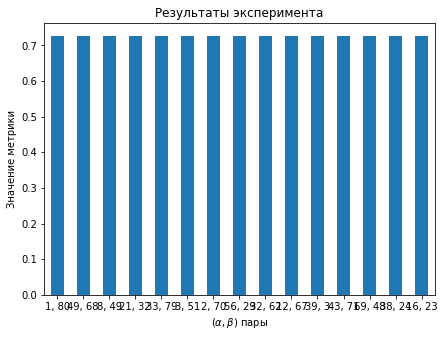

In [39]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [40]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

01-Nov-19 12:37:43, root, DEBUG: Проверка датафреймов
01-Nov-19 12:37:43, root, DEBUG: Предварительная стадия обучения (pre-fit)
01-Nov-19 12:37:44, root, DEBUG: Среднее количество items у каждого user: 37.0
01-Nov-19 12:37:44, root, DEBUG: Основная стадия обучения (fit)
01-Nov-19 12:37:44, root, DEBUG: Проверка датафреймов
01-Nov-19 12:37:44, root, DEBUG: Выделение дефолтных юзеров
01-Nov-19 12:37:44, root, DEBUG: Выделение дефолтных айтемов
01-Nov-19 12:37:48, root, DEBUG: Количество items после фильтрации: 47


CPU times: user 28 ms, sys: 24 ms, total: 52 ms
Wall time: 5.59 s


In [41]:
best_recs.show(10)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2903| 100010|no_context| 0.01047610318801781|
|  37337| 100010|no_context|0.008376619639656153|
|  57335| 100010|no_context|0.006875648761730...|
|   2962| 100010|no_context|0.006833659090763764|
|  65750| 100010|no_context|0.006062711680162332|
|  32146| 100010|no_context|0.005988963324047292|
|  71934| 100010|no_context|0.005025758638255788|
|  58247| 100010|no_context|0.004495665685486708|
|  33182| 100010|no_context|0.004337511696361393|
|  32858| 100010|no_context|0.003866033766516115|
+-------+-------+----------+--------------------+
only showing top 10 rows



## Рекомендатель на основе k-NN для объектов (item k-NN based recommender) <a name='knn-recommender'></a>

### Запуск single модели <a name='knn-recommender-single'></a>

In [43]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_randomly(
    df, test_size=0.2,
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(3752684, 3752684, 935591)

In [44]:
knn = KNNRecommender(spark, num_neighbours=15, shrink=0)

In [45]:
%%time

knn.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

01-Nov-19 12:51:19, root, DEBUG: Проверка датафреймов
01-Nov-19 12:51:21, root, DEBUG: Предварительная стадия обучения (pre-fit)
01-Nov-19 12:51:22, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 3.07 s


In [57]:
%%time

recs = knn.predict(
    k=10,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

01-Nov-19 14:54:52, root, DEBUG: Проверка датафреймов


CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 4.02 s


In [47]:
recs.show(5)

+-------+-------+--------------------+----------+
|item_id|user_id|           relevance|   context|
+-------+-------+--------------------+----------+
|  42693| 100010| 0.01872605768906605|no_context|
|  71934| 100010| 0.01703401656540512|no_context|
|   2903| 100010|0.016301770839161542|no_context|
|    891| 100010|0.016058033827085164|no_context|
|  30047| 100010|0.014517152435516604|no_context|
+-------+-------+--------------------+----------+
only showing top 5 rows



In [58]:
%%time

metric = Metrics.hit_rate_at_k(recs, test, k=100)
metric

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 15.3 s


0.32429219796844605

### Подбор гиперпараметров в item k-NN модели <a name='knn-recommender-scenario'></a>

In [49]:
knn_scenario = KNNScenario(spark)
knn_scenario.seed = 3951

In [62]:
%%time

knn_params_grid = {
    'num_neighbours': (10, 100, 5), 
    'shrink': [0]
}

best_params = knn_scenario.research(
    knn_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.2,
    k=10, context='no_context',
    to_filter_seen_items=True,
    n_trials=15, 
    n_jobs=1,
    how_to_split='randomly'
)

01-Nov-19 15:04:36, root, DEBUG: Деление на трейн и тест
01-Nov-19 15:04:36, root, DEBUG: Длина трейна и теста: (3751580, 936135)
01-Nov-19 15:04:37, root, DEBUG: Количество юзеров в трейне и тесте: 128122, 120405
01-Nov-19 15:04:37, root, DEBUG: Количество айтемов в трейне и тесте: 68735, 46425
01-Nov-19 15:04:37, root, DEBUG: Популярная модель: фит_предикт
01-Nov-19 15:04:37, root, DEBUG: Проверка датафреймов
01-Nov-19 15:04:37, root, DEBUG: Предварительная стадия обучения (pre-fit)
01-Nov-19 15:04:38, root, DEBUG: Среднее количество items у каждого user: 30.0
01-Nov-19 15:04:38, root, DEBUG: Основная стадия обучения (fit)
01-Nov-19 15:04:38, root, DEBUG: Проверка датафреймов
01-Nov-19 15:04:40, root, DEBUG: Количество items после фильтрации: 40
01-Nov-19 15:04:41, root, DEBUG: Модель KNN
01-Nov-19 15:04:41, root, DEBUG: Первый пре-фит модели
01-Nov-19 15:04:41, root, DEBUG: -------------
01-Nov-19 15:04:41, root, DEBUG: Начало оптимизации параметров
01-Nov-19 15:04:41, root, DEBUG: 

CPU times: user 2.71 s, sys: 472 ms, total: 3.18 s
Wall time: 21min 13s


In [63]:
knn_results = knn_scenario.study.trials_dataframe()

knn_results

number                state     value             datetime_start  \
                                                                      
0   0      TrialState.COMPLETE  0.308625 2019-11-01 15:04:41.386398   
1   1      TrialState.COMPLETE  0.325003 2019-11-01 15:06:53.722944   
2   2      TrialState.COMPLETE  0.302911 2019-11-01 15:07:48.707318   
3   3      TrialState.COMPLETE  0.308625 2019-11-01 15:10:00.043280   
4   4      TrialState.COMPLETE  0.325003 2019-11-01 15:10:29.057456   
5   5      TrialState.COMPLETE  0.297654 2019-11-01 15:10:59.404881   
6   6      TrialState.COMPLETE  0.330402 2019-11-01 15:13:37.009504   
7   7      TrialState.COMPLETE  0.326249 2019-11-01 15:14:42.639996   
8   8      TrialState.COMPLETE  0.305810 2019-11-01 15:16:06.438109   
9   9      TrialState.COMPLETE  0.312088 2019-11-01 15:18:08.534832   
10  10     TrialState.COMPLETE  0.314846 2019-11-01 15:19:57.311861   
11  11     TrialState.COMPLETE  0.305810 2019-11-01 15:21:56.328005   
12  12     TrialState.COMPLETE  0.308625 2019-11-01 15:22:28.450741   
13  13     TrialState.COMPLETE  0.302280 2019-11-01 15:22:57.522693   
14  14     TrialState.COMPLETE  0.308625 2019-11-01 15:25:13.273275   

            datetime_complete         params        user_attrs system_attrs  
                              num_neighbours shrink     nDCG@k      _number  
0  2019-11-01 15:06:53.720279  70.0           0      0.072053   0            
1  2019-11-01 15:07:48.703018  15.0           0      0.084293   1            
2  2019-11-01 15:10:00.040025  80.0           0      0.069882   2            
3  2019-11-01 15:10:29.053987  70.0           0      0.072053   3            
4  2019-11-01 15:10:59.401451  15.0           0      0.084293   4            
5  2019-11-01 15:13:37.005776  100.0          0      0.067725   5            
6  2019-11-01 15:14:42.636085  20.0           0      0.085703   6            
7  2019-11-01 15:16:06.434104  35.0           0      0.081290   7            
8  2019-11-01 15:18:08.530447  75.0           0      0.070923   8            
9  2019-11-01 15:19:57.306601  65.0           0      0.073104   9            
10 2019-11-01 15:21:56.323363  60.0           0      0.074371   10           
11 2019-11-01 15:22:28.445779  75.0           0      0.070923   11           
12 2019-11-01 15:22:57.517628  70.0           0      0.072053   12           
13 2019-11-01 15:25:13.267848  85.0           0      0.069390   13           
14 2019-11-01 15:25:50.204179  70.0           0      0.072053   14

## Рекомендатель на основе нейросетки (neural CF) <a name='neurocf-recommender'></a>

### Запуск single модели <a name='neurocf-recommender-single'></a>

In [21]:
1

1

In [23]:
ncf = NeuroCFRecommender(spark,
                         learning_rate=0.01,
                         epochs=10,
                         batch_size=100000,
                         embedding_dimension=100)

In [24]:
%%time

ncf._pre_fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

CPU times: user 4.85 s, sys: 1.13 s, total: 5.98 s
Wall time: 13.2 s


In [25]:
%%time

ncf._fit_partial(
    log=train,
    user_features=None,
    item_features=None,
    path="/data/aysina-rm/code/sponge-bob-magic/data"
)

18-Nov-19 15:07:15, root, DEBUG: Индексирование данных
18-Nov-19 15:07:15, root, DEBUG: Составление батча:
18-Nov-19 15:07:15, root, DEBUG: -- Запись
18-Nov-19 15:07:19, root, DEBUG: -- Считывание
18-Nov-19 15:07:20, root, DEBUG: Эпоха 0
18-Nov-19 15:07:26, root, DEBUG: Текущее значение: 0.7365
18-Nov-19 15:07:26, root, DEBUG: Эпоха 1
18-Nov-19 15:07:32, root, DEBUG: Текущее значение: 0.3243
18-Nov-19 15:07:32, root, DEBUG: Эпоха 2
18-Nov-19 15:07:38, root, DEBUG: Текущее значение: 0.2415
18-Nov-19 15:07:38, root, DEBUG: Эпоха 3
18-Nov-19 15:07:44, root, DEBUG: Текущее значение: 0.1983
18-Nov-19 15:07:44, root, DEBUG: Эпоха 4
18-Nov-19 15:07:50, root, DEBUG: Текущее значение: 0.1685
18-Nov-19 15:07:50, root, DEBUG: Эпоха 5
18-Nov-19 15:07:56, root, DEBUG: Текущее значение: 0.1468
18-Nov-19 15:07:56, root, DEBUG: Эпоха 6
18-Nov-19 15:08:02, root, DEBUG: Текущее значение: 0.1312
18-Nov-19 15:08:02, root, DEBUG: Эпоха 7
18-Nov-19 15:08:08, root, DEBUG: Текущее значение: 0.1195
18-Nov-19 1

CPU times: user 20.4 s, sys: 10.9 s, total: 31.4 s
Wall time: 1min 4s


In [29]:
%%time

recs = ncf.predict(
    k=10,
    users=test.select('user_id').distinct().limit(10),
    items=test.select('item_id').distinct().limit(10),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path="/data/aysina-rm/code/sponge-bob-magic/data"
)

18-Nov-19 15:43:02, root, DEBUG: Проверка датафреймов
18-Nov-19 15:43:08, root, DEBUG: Индексирование пользователей и объектов
18-Nov-19 15:43:08, root, DEBUG: -- Запись
18-Nov-19 15:43:11, root, DEBUG: -- Считывание
18-Nov-19 15:43:11, root, DEBUG: -- Запись
18-Nov-19 15:43:18, root, DEBUG: -- Считывание
18-Nov-19 15:43:18, root, DEBUG: Создание тензоров
18-Nov-19 15:43:18, root, DEBUG: Предсказание модели
18-Nov-19 15:43:18, root, DEBUG: Преобразование numpy-массива в спарк-датафрейм
18-Nov-19 15:43:18, root, DEBUG: -- Запись
18-Nov-19 15:43:18, root, DEBUG: -- Считывание
18-Nov-19 15:43:18, root, DEBUG: Обратное преобразование индексов
18-Nov-19 15:43:35, root, DEBUG: Преобразование отрицательных relevance
18-Nov-19 15:43:42, root, DEBUG: Запись на диск рекомендаций


CPU times: user 13.4 s, sys: 2.54 s, total: 16 s
Wall time: 42.6 s


In [30]:
recs.show()

+-------+-------+-------------------+----------+
|item_id|user_id|          relevance|   context|
+-------+-------+-------------------+----------+
| 108839|   2962|0.45305297406499945|no_context|
|  96252|   2962| 0.3782860818333428|no_context|
| 100912|   2962|0.33975436514120194|no_context|
| 252131|   2962| 0.3376987508274953|no_context|
|  97726|   2962|0.31785102101036755|no_context|
| 232557|   2962|0.31136588940131893|no_context|
| 231256|   2962|0.30358328940286616|no_context|
| 252794|   2962| 0.2581674750977798|no_context|
| 264023|   2962| 0.2529378154566724|no_context|
| 230802|   2962|0.18167872958614736|no_context|
| 264023|   5670| 0.2848539905994326|no_context|
| 232557|   5670|0.27243962738122474|no_context|
| 231256|   5670|0.18167872958614736|no_context|
|  96252|   5670|0.18167872958614736|no_context|
| 108839|   5670|0.18167872958614736|no_context|
| 230802|   5670|0.18167872958614736|no_context|
| 252794|   5670|0.18167872958614736|no_context|
| 100912|   5670|0.1